In [1]:
import numpy as np
import pandas as pd
from sympy import *
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
x1, x2, lamb = symbols('x1 x2 lamb')
X0 = [-1.2, 0]
f = (10*(x1-x2)**2 + (x1-1)**2)**4

In [3]:
def norma(x):
    return LA.norm(x)
def step(xi, si):
    return 0.1 * norma(xi)/norma(si)
def determine_direction(min_f, x, s):
    f_minus_step = min_f.subs([(x1, x[0]-step(x, s)*s[0]), (x2, x[1]-step(x, s)*s[1])])
    f_plus_step = min_f.subs([(x1, x[0]+step(x, s)*s[0]), (x2, x[1]+step(x, s)*s[1])])
    f_0 = min_f.subs([(x1, x[0]), (x2, x[1])])
    if (f_minus_step > f_0) and (f_0 > f_plus_step):
        return 1.0
    elif (f_minus_step < f_0) and (f_0 < f_plus_step):
        return -1.0
    else:
        return 0

def Swen(min_f, x_old, x, s):
    if abs(determine_direction(min_f, x, s)) == 1:
        k=0
        x_list = [x_old]
        while(True):
            x_new = x_old + determine_direction(min_f, x,  s) * step(x, s) * 2**k
            x_list.append(x_new)
    
            if min_f.subs([(x1, x[0]+x_new*s[0]), (x2, x[1]+x_new*s[1])]) < min_f.subs([(x1, x[0]+x_old*s[0]), (x2, x[1]+x_old*s[1])]):
                x_old = x_new
                k += 1
                continue
            else:
                break
        return [x_list[-3], x_list[-2], sum(x_list[-2:]) / 2]
    else:
        return [-step(x, s), 0, step(x, s)]
    
def golden(interval, min_f, x, s):
    len_ = interval[2] - interval[0]
    values = [interval[0], interval[0]+0.382*len_,interval[0]+0.618*len_, interval[2]]
    func_val = [min_f.subs([(x1, x[0]+i*s[0]), (x2, x[1]+i*s[1])]) for i in values]
    values.pop(func_val.index(max(func_val)))
    if values[2] - values[0] < 0.1:
        return values[1]
    else:
        return golden(values, min_f, x, s)
    
def DSK(values, min_f, x, s):
    values = [round(x, 14) for x in values]
    if round(values[2] - values[1], 14) == round(values[1] - values[0], 14):
        func_val = [min_f.subs([(x1, x[0]+i*s[0]), (x2, x[1]+i*s[1])]) for i in values]
        delt = values[1] - values[0]
        x_ = values[1] + delt*(func_val[0] - func_val[2]) / (2*(func_val[0] - 2*func_val[1] + func_val[2]))
        if (values[1] - x_ < 0.01) and (func_val[1] - min_f.subs([(x1, x[0]+x_*s[0]), (x2, x[1]+x_*s[1])]) < 0.01):
            return x_
        else:
            values.pop(func_val.index(max(func_val)))
            new_vals = [min(values), x_, max(values)]
            return DSK(new_vals, min_f, x, s)
    else:
        f_new_vals = [min_f.subs([(x1, x[0]+i*s[0]), (x2, x[1]+i*s[1])]) for i in values]
        a1 = (f_new_vals[1] - f_new_vals[0]) / (values[1] - values[0])
        a2 = ((f_new_vals[2] - f_new_vals[0]) / (values[2] - values[0]) \
            - (f_new_vals[1] - f_new_vals[0]) / (values[1] - values[0])) \
            / (values[2] - values[1]) 
        x_ = (values[0] + values[1])/2 - a1/2/a2
        if (values[1] - x_ < 0.01) and (f_new_vals[1] - min_f.subs([(x1, x[0]+x_*s[0]), (x2, x[1]+x_*s[1])]) < 0.01):
            return x_
        else:
            values.pop(f_new_vals.index(max(f_new_vals)))
            new_vals = [min(values), x_, max(values)]
            return DSK(new_vals, min_f, x, s)

In [16]:
def search_next_point(X, r):
    x = np.linspace(X[0]-r, X[0]+r, 100)
    y = [(r**2 - (xi-X[0])**2 + X[1])**0.5 for xi in np.flip(x)]
    points = pd.DataFrame({'x': np.hstack((x, np.flip(x))), 'y': np.hstack((y, -np.flip(y)))}).fillna(0)
    f_value = [f.subs([(x1, i[0]), (x2, i[1])]) for i in list(zip(points['x'], points['y']))]
    points['f_val'] = f_value
    x_min = points[points['f_val']==np.min(f_value)].x.values[0]
    y_min = points[points['f_val']==np.min(f_value)].y.values[0]
    s = np.array([x_min, y_min]) - X
    conf_int = Swen(f, 0, X, s)
    lamb = golden(conf_int, f, X, s)
    # lamb = DSK(conf_int, f, X, s)
    X_new = (X + lamb*s).astype('float64')
    
    return X_new

In [17]:
list_normals = [np.inf]
f_values = []
def random_method(X_old, r, n=0):
    
    X_new = search_next_point(X_old, r)
    print(X_new)
    
    list_normals.append(norma(X_new - X_old))
    f_values.append(f.subs([(x1, X_new[0]), (x2, X_new[1])]))
    
    if (list_normals[-1] < 0.001) and ((f_values[-1] - f_values[-2]) < 0.001):
        return X_new, n
    else:
        n += 1
        return random_method(X_new, r, n)

In [25]:
ans = random_method(X0, 0.1)

print("\nТочка: ", ans[0], "\nКількість ітерацій: ", ans[1], "\nНорма: ", list_normals[-1], "\nЗначення функції: ", f_values[-1])

<ipython-input-16-9027a9dc4987>:3: RuntimeWarning: invalid value encountered in double_scalars
  y = [(r**2 - (xi-X[0])**2 + X[1])**0.5 for xi in np.flip(x)]


[-0.43632587 -0.6421784 ]
[-0.39374296 -0.36872011]
[-0.38388355 -0.33236648]
[-0.38049314 -0.32109791]
[-0.37913348 -0.31673206]
[-0.37857249 -0.31495523]
[-0.37833574 -0.31420958]

Точка:  [-0.37833574 -0.31420958] 
Кількість ітерацій:  6 
Норма:  0.0007823314606501266 
Значення функції:  14.1918967437768


In [ ]:
def search_next_point(X, r):
    x = np.linspace(X[0]-r, X[0]+r, 100)
    y = [(r**2 - (xi-X[0])**2 + X[1])**0.5 for xi in np.flip(x)]
    points = pd.DataFrame({'x': np.hstack((x, np.flip(x))), 'y': np.hstack((y, -np.flip(y)))}).fillna(0)
    f_value = [f.subs([(x1, i[0]), (x2, i[1])]) for i in list(zip(points['x'], points['y']))]
    points['f_val'] = f_value
    x_min = points[points['f_val']==np.min(f_value)].x.values[0]
    y_min = points[points['f_val']==np.min(f_value)].y.values[0]
    s = np.array([x_min, y_min]) - X
    conf_int = Swen(f, 0, X, s)
    # lamb = golden(conf_int, f, X, s)
    lamb = DSK(conf_int, f, X, s)
    X_new = (X + lamb*s).astype('float64')
    
    return X_new

In [23]:
ans = random_method(X0, 0.1)

print("\nТочка: ", ans[0], "\nКількість ітерацій: ", ans[1], "\nНорма: ", list_normals[-1], "\nЗначення функції: ", f_values[-1])

<ipython-input-16-9027a9dc4987>:3: RuntimeWarning: invalid value encountered in double_scalars
  y = [(r**2 - (xi-X[0])**2 + X[1])**0.5 for xi in np.flip(x)]


[-0.12857684 -0.23038522]
[0.93283866 0.96790832]
[1.00632226 1.04052218]
[1.00939666 1.0435263 ]
[1.00994797 1.044062  ]

Точка:  [1.00994797 1.044062  ] 
Количество итераций:  4 
Норма:  0.0007687134073734369 
Значение функции в этой точке:  1.89746531727439e-8


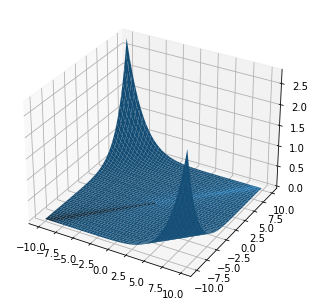

In [22]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
import numpy
x = numpy.arange (-10, 10, 0.1)
y = numpy.arange (-10, 10, 0.1)
xgrid, ygrid = numpy.meshgrid(x, y)
zgrid = (10*(xgrid-ygrid)**2 + (xgrid-1)**2)**4
fig = pylab.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, zgrid)
pylab.show()

<IPython.core.display.Javascript object>


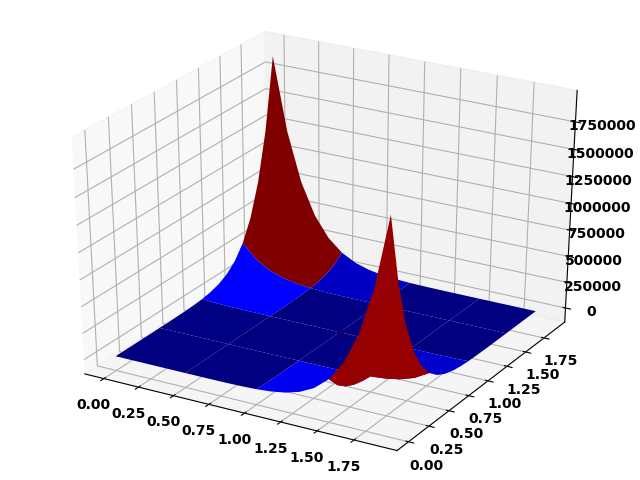

In [137]:
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import numpy
%matplotlib notebook
x = numpy.arange (0, 2, 0.1)
y = numpy.arange (0, 2, 0.1)
xgrid, ygrid = numpy.meshgrid(x, y)
zgrid = (10*(xgrid-ygrid)**2 + (xgrid-1)**2)**4
x, y, z = makeData()
fig = pylab.figure()
axes = Axes3D(fig)
axes.plot_surface(xgrid, ygrid, zgrid, rstride=5, cstride=5, cmap = cm.jet)
axes.scatter(1, 1, 0, color='red')
pylab.show()

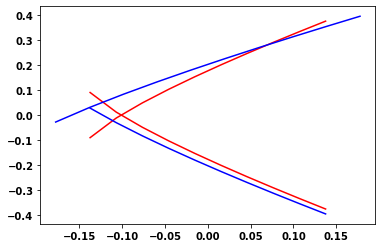

In [330]:
y = ((2**(0.25) - 1)/10)**0.5
xi = np.linspace(-y, y, 10)
ys = [f.subs([(x1, x), (x2, x2)]) for x in xi]
yi = np.array([solve(eq-2, x2) for eq in ys])
yi = [i[1] for i in yi]
y2 = ((3**(0.25) - 1)/10)**0.5
xi2 = np.linspace(-y2, y2, 10)
ys2 = [f.subs([(x1, x), (x2, x2)]) for x in xi]
yi2 = np.array([solve(eq-3, x2) for eq in ys2])
yi2 = [i[1] for i in yi2]
plt.plot(xi, yi, color='r')
plt.plot(xi, [-i for i in yi], color='r')
plt.plot(xi2, yi2, color='b')
plt.plot(xi, [-i for i in yi2], color='b')